## 합성곱 신경망
### 파이토치로 패션 MNIST CNN 실습
- 텐서플로(케라스)로 CNN을 하든, 파이토치로 CNN하든 아무 차이가 없음

#### 데이터셋 불러오기

- 이전에는 sklearn에 있는 StandardScaler 사용
- 이번에는 torchvision에 있는 transforms의 Compose() 사용

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

- 다운로드 받은 데이터는 gitignore에 적어야함. 깃허브에 올리지 않도록
- <img src = './gitignore추가.png'>

In [4]:
# 정규화 및 텐서 변환
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,),(0.5,))        #Fashion MNIST 자주 사용하는 정규화 범위
])


#패션 mnist를 가져와서 데이터셋으로 변경
#keras는 C:\Users\Admin\.keras\datasets
#Pytorch는 현재위치에 다운로드(C:\Source\iot_dataanalysis_2025\day51) 
#다운로드 받은 데이터는 gitignore에 적어야함. 깃허브에 올리지 않도록

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.FashionMNIST(root='./data', train=False, transform= transform)
# 데이터셋을 데이터로드로 변경
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
 

|레이블|0|1|2|3|4|5|6|7|8|9|
|:---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|패션MNIST|티셔츠|바지|스웨터|드레스|코드|샌달|셔츠|스니커즈|가방|앵클 부츠|

##### CNN 모델정의

In [6]:
import torch.nn as nn                        # 신경망을 만들 때 필요한 기본 레이어들과 기능을 제공하는 PyTorch의 모듈입니다.
import torch.nn.functional as F             # 활성화 함수 같은 다양한 함수형 연산들을 제공합니다

class CNN(nn.Module) :
    def __init__(self):
        super(CNN, self).__init__()


        #입력 채널 수가 1 (예: MNIST의 흑백 이미지), 출력 채널 수는 32 (필터 32개 사용).
        #커널 크기는 3x3, padding=1을 주어 이미지 크기가 유지되도록 합니다.
        self.conv1= nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)

        #이미지의 크기를 절반으로 줄입니다. (예: 28x28 → 14x14)
        self.pool = nn.MaxPool2d(2,2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # 채널 수: 64 (conv2의 출력 채널 수) 
        # 너비, 높이: 7x7
        # 출력: 128개의 숫자/즉, 이미지 특징들을 3136차원 → 128차원으로 압축하는 거예요.
        self.fc1 = nn.Linear(64*7*7,128)
        self.fc2 = nn.Linear(128,10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))      #→ 28x28 → 14x14
        x = self.pool(F.relu(self.conv2(x)))      # → 14x14 → 7x7
        
        # x는 지금 4차원 텐서예요: [배치크기, 채널, 높이, 너비] → 예: [64, 64, 7, 7]
        # 완전 연결층(fc1)은 2D 텐서만 받습니다 → [배치크기, 특징수]
        #그래서 view()를 써서 평탄화(flatten) 해주는 거예요.
        x = x.view(-1,64*7*7)

        # 첫 번째 완전 연결층(fc1)을 통과시켜서 3136 → 128 차원으로 줄입니다.
        #그 후 ReLU 활성화 함수로 음수는 0, 양수는 그대로 통과시킵니다.
        x = F.relu(self.fc1(x))

        #두 번째 완전 연결층(fc2)은 128 → 10차원으로 변환해요.
        #그리고 softmax 함수를 적용해서 10개의 확률로 변환합니다.
        x = F.softmax(self.fc2(x))

        return x

#####  훈련 /평가 루프

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [15]:
#훈련함수
def train(model, dataloader, criterion, optimizer) :
    model.train()   # 훈련모드
    total_loss = 0
    
    for X_batch, y_batch in dataloader :
        X_batch, y_batch = X_batch.to(device) , y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
            
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss


In [16]:
#평가함수
def evaluate (model, dataloader, criterion) :
    model.eval()    #평가모드
    total_loss =0
    correct = 0
    total =0

    with torch.no_grad() : #평가시에는 그레디언트 꺼줌
        for X_batch, y_batch in dataloader:
             X_batch, y_batch = X_batch.to(device) , y_batch.to(device)
             outputs = model(X_batch)
             loss = criterion(outputs, y_batch)
             total_loss += loss.item()

             #정확도
             # preds는 모델의 예측 결과에서 가장 확률이 높은 클래스의 인덱스를 의미
             #타겟인 0,1,2 중에서 제일 확률이 큰 값의 인덱스 하나 선택
             preds =torch.argmax(outputs, dim=1) 

             # .sum()을 하면 맞춘 예측의 개수를 합산할 수 있습니다. 
             # 이를 correct에 더해주고, item()을 사용하여 텐서 값을 일반적인 숫자 형식으로 변환합니다.
             correct += (preds == y_batch).sum().item()

             #y_batch.size(0)는 현재 배치의 크기를 의미합니다. 
             # 즉, 전체 데이터의 샘플 개수를 계속 더해가며 총 샘플 수를 추적합니다.
             total += y_batch.size(0)

        avg_loss = total_loss / len(dataloader)
        # correct는 예측이 맞은 샘플의 총 개수이고, total은 전체 샘플의 개수입니다. 
        # 이 두 값을 나누면 전체 데이터에 대한 정확도가 구해집니다.
        accuracy = correct / total
        return avg_loss, accuracy

In [17]:
EPOCH = 10
for epoch in range(EPOCH):
    train_loss = train(model, train_loader, criterion, optimizer)
    val_loss , val_acc = evaluate(model, val_loader, criterion)

    print(f'[{epoch+1}/{EPOCH}] Train Loss : {train_loss:.3f} | Val Loss : {val_loss:.3f} | Val Accuaracy :{val_acc:.2%}')

C:\Users\Admin\AppData\Local\Temp\ipykernel_13872\4276118313.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


[1/10] Train Loss : 1.510 | Val Loss : 1.548 | Val Accuaracy :91.29%
[2/10] Train Loss : 1.507 | Val Loss : 1.547 | Val Accuaracy :91.37%
[3/10] Train Loss : 1.505 | Val Loss : 1.551 | Val Accuaracy :91.02%
[4/10] Train Loss : 1.506 | Val Loss : 1.547 | Val Accuaracy :91.37%
[5/10] Train Loss : 1.505 | Val Loss : 1.546 | Val Accuaracy :91.46%
[6/10] Train Loss : 1.504 | Val Loss : 1.550 | Val Accuaracy :90.98%
[7/10] Train Loss : 1.502 | Val Loss : 1.548 | Val Accuaracy :91.36%
[8/10] Train Loss : 1.502 | Val Loss : 1.548 | Val Accuaracy :91.31%
[9/10] Train Loss : 1.502 | Val Loss : 1.549 | Val Accuaracy :91.13%
[10/10] Train Loss : 1.502 | Val Loss : 1.547 | Val Accuaracy :91.32%


##### 훈련 데이터 시각화

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [19]:
from matplotlib import rcParams, font_manager, rc

font_path = 'C:/Windows/Fonts/malgun.ttf' # 나눔고딕코딩 사용, 나눔고딕에서 오류발생(!)
font = font_manager.FontProperties(fname=font_path).get_name() # 실제 설치된 폰트 이름조회
rc('font', family=font) # 한글깨짐현상 해결!!
rcParams['axes.unicode_minus'] = False # 한글 사용시 마이너스 표시 깨짐 해결!

In [20]:
# 시본 형태로 차트 변경
sns.set_style('darkgrid')

# 시본 사용시 한글깨짐 해결
sns.set_theme(font='Malgun Gothic', rc={'axes.unicode_minus':False}) 

In [21]:
class_names = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈', '가방', '앵클부츠']

In [22]:
#데이터로더에서 하나만 꺼내기
dataloader = DataLoader(train_dataset, batch_size=9, shuffle=True)
images, labels = next(iter(dataloader))    #배치 하나만 추출


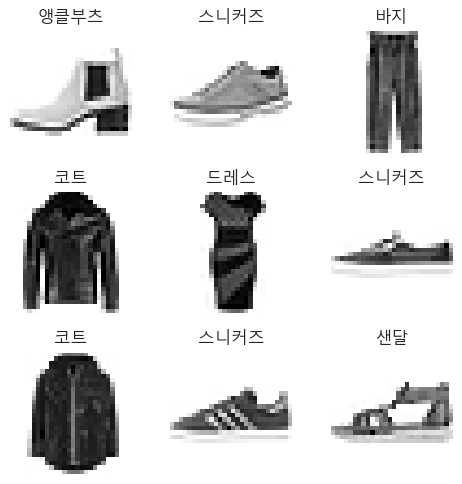

In [24]:
plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3, 3, i+1)

    # 0]을 사용하는 이유는, 첫 번째 채널을 선택하기 위함입니다. 
    # 예를 들어, 흑백 이미지라면 images[i][0]은 이미지를 그대로 나타내지만, 
    # 컬러 이미지라면 첫 번째 채널(빨간색, 녹색, 파란색 중 하나)을 선택하는 것이죠.
    plt.imshow(images[i][0], cmap='gray_r')
    plt.axis('off')
    plt.title(class_names[labels[i]])

plt.tight_layout()
plt.show()


##### 예측결과 시각화 - 테스트데이터

In [25]:
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)


C:\Users\Admin\AppData\Local\Temp\ipykernel_13872\4276118313.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


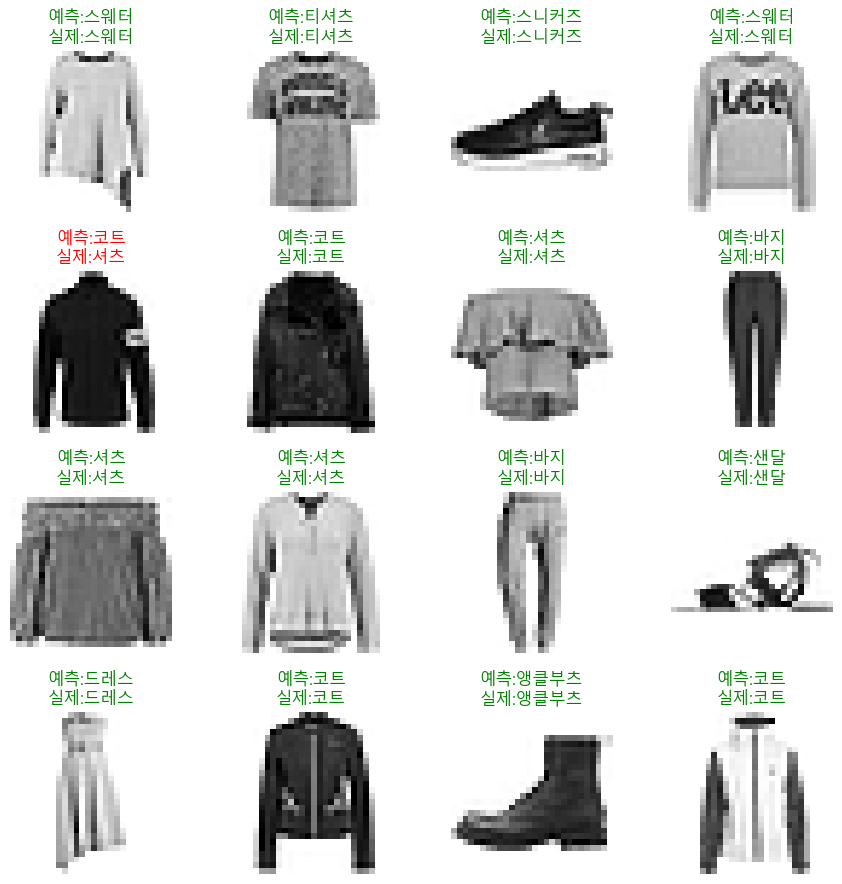

In [34]:
# 테스트 배치 하나만 가져오기
images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

#모델을 검증모드
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

#예측값 시각화. 시각화 때는 cuda를 못 씀
plt.figure(figsize=(9,9))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i].cpu().squeeze(), cmap='gray_r')
    plt.axis('off')
    plt.title(f'예측:{class_names[preds[i]]}\n실제:{class_names[labels[i]]}', color = 'green' if preds[i]==labels[i] else  'red')

plt.tight_layout()
plt.show()

##### 모델 저장 및 로드
- 가중치만 저장
- 전체 모델 저장

In [35]:
# 가중치만 저장
#pytorch 모델 확장자 .pth
torch.save(model.state_dict(), './fashion_mnist_cnn.pth') 


In [36]:
# 가중치 저장만 저장한 모델을 쓰려면 모델을 직접 생성해야 함
model2 = CNN().to(device)
model2.load_state_dict(torch.load('./fashion_mnist_cnn.pth', map_location=device))
model2

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [37]:
#전체모델 저장
torch.save(model, './fashion_mnist_full.pth')

In [39]:
# 전체모델 저장은 그냥 쓰면 됨
model3 = torch.load('./fashion_mnist_full.pth' , weights_only=False)
model3

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)